# Note: log likelihood here seems to be lower to that with a scalar lenghtscale for hyperparams. This is probably not very useful code now

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
import ast
import emcee
import corner
import seaborn as sns

# PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Get the data

In [2]:
# Load the saved array - gives Boost(i = sample point, z, k)
Bk_arr = np.load('Boost.npy')
print(Bk_arr.shape)

(50, 51, 768)


In [3]:
# extract data from text file - gives z and k arrays
txt_arr = np.loadtxt("z_k.txt")

z_arr = np.array(txt_arr.T[0][np.isfinite(txt_arr.T[0])])
k_arr = np.array(txt_arr.T[1])

print(z_arr.shape)
print(k_arr.shape)

(51,)
(768,)


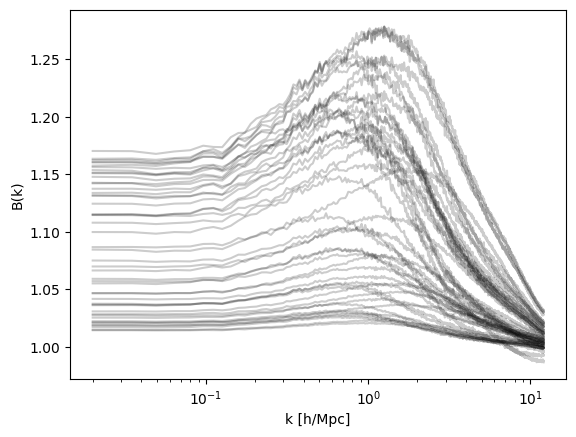

In [4]:
# Plot data

z_index = 12

plt.figure(32)
for sim_index in range(49):
    plt.plot(k_arr, Bk_arr[sim_index, z_index, :], 'k', alpha=0.2)
    

plt.ylabel("B(k)")
plt.xlabel("k [h/Mpc]")
plt.xscale('log')
plt.show()
     


In [5]:
# Get the parameter - for now assume only one parameter, w_m
txt = "cosmo_newdesign"
hcube = np.loadtxt(txt).T
f_phi = 10**hcube[4]
h = hcube[3]
Omega_m = hcube[0]
n_s = hcube[1]
A_s = hcube[2]

theta_1 = np.array([Omega_m,f_phi, h, n_s, A_s])

"""
    wb = 0.0223
    wr = 4.28e-5
"""


'\n    wb = 0.0223\n    wr = 4.28e-5\n'

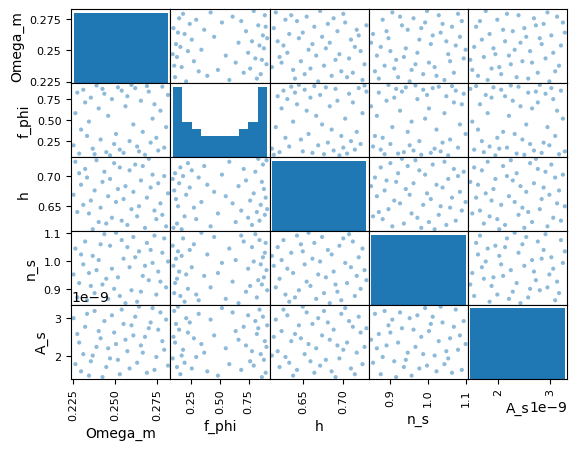

In [6]:
df_theta = pd.DataFrame(theta_1.T, columns=['Omega_m','f_phi', 'h', 'n_s', 'A_s'][:len(theta_1)])
pd.plotting.scatter_matrix(df_theta)
plt.show()


## Create the emulator

In [11]:
# Useful functions to define

"""Functions for GP conditional distributions"""

# Define the Squared Exponential (SE) covariance function
def SE_kernel(xa, xb, standard_dev, lengthscale):
    
    """Exponentiated quadratic
    xa --> (ma, n), where ma is the number of gaussian vectors (n points in function)
                    and n is the dimension of the vector theta
    xb --> (mb, n)
    standard_dev --> standard deviation of function
    lengthscale --> characteristic length scale"""
    
    # Squared of Euclidian distance [Dist_{a,b} = xa - xb]
    
    
    sq_norm = -0.5 * (scipy.spatial.distance.cdist(xa/lengthscale, xb/lengthscale, 'euclidean') **2)
    return standard_dev**2 * np.exp(sq_norm)

# Gaussian process posterior with no noise
def GP(X1, y1, X2, kernel_func):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the observations (y1, X1), 
    and the prior kernel function.
    """
    # Kernel of the observations
    K11 = kernel_func(X1, X1)
    # Kernel of observations vs to-predict
    K12 = kernel_func(X1, X2)
    # Solve - returns (K11^-1 * K12)^T, assuming positive definite solutions
    solved = scipy.linalg.solve(K11, K12, assume_a='pos').T
    # Compute posterior mean
    mean2 = solved @ y1
    # Compute the posterior covariance
    K22 = kernel_func(X2, X2)
    K2 = K22 - (solved @ K12)
    return mean2, K2  # mean, covariance

"""Functions for hyperparameter MCMC"""

# Find likelihood for given sigma, ell given theta, w_theta from simulations
def log_likelihood(theta, w_theta, params):

    """
    theta --> array (n_param, n_sim)
    w_theta --> array (n_sim, n_PCs)
    6 hyperparameters: ell and sigma for each w_theta
    """
    sigma1, ell1_Om , ell1_fphi , ell1_h , ell1_ns , ell1_As, sigma2, \
    ell2_Om , ell2_fphi , ell2_h , ell2_ns,ell2_As,sigma3, ell3_Om , ell3_fphi , ell3_h , ell3_ns , ell3_As = params
    
    n1 = len(theta[0])  # Number of points to condition on (training points)
    kernel_func_1 = lambda x, y: SE_kernel(x, y, sigma1, np.array([ell1_Om , ell1_fphi , ell1_h , ell1_ns , ell1_As]))
    kernel_func_2 = lambda x, y: SE_kernel(x, y, sigma2, np.array([ell2_Om , ell2_fphi , ell2_h , ell2_ns , ell2_As]))
    kernel_func_3 = lambda x, y: SE_kernel(x, y, sigma3, np.array([ell3_Om , ell3_fphi , ell3_h , ell3_ns , ell3_As]))
    # Sample observations (X1, y1) on the function
    X1 = theta.T

    y_1 = w_theta.T[0].reshape(-1, 1)
    y_2 = w_theta.T[1].reshape(-1, 1)
    y_3 = w_theta.T[2].reshape(-1, 1)


    # Draw samples from the prior at our data points
    # Assume mean of 0 for prior
    covariance_1 = kernel_func_1(X1, X1)
    inv_cov1 = np.linalg.inv(covariance_1)
    covariance_2 = kernel_func_2(X1, X1)
    inv_cov2 = np.linalg.inv(covariance_2)
    covariance_3 = kernel_func_3(X1, X1)
    inv_cov3 = np.linalg.inv(covariance_3)

    lik_1 = -0.5*np.dot(np.dot(y_1.T, inv_cov1), y_1) -0.5*np.log10(np.linalg.det(covariance_1))
    lik_2 = -0.5*np.dot(np.dot(y_2.T, inv_cov2), y_2) -0.5*np.log10(np.linalg.det(covariance_2))
    lik_3 = -0.5*np.dot(np.dot(y_3.T, inv_cov3), y_3) -0.5*np.log10(np.linalg.det(covariance_3))

    return (lik_1 + lik_2 + lik_3)[0][0]

def log_prior(params):
    sigma1, ell1_Om , ell1_fphi , ell1_h , ell1_ns , ell1_As, sigma2, \
    ell2_Om , ell2_fphi , ell2_h , ell2_ns,ell2_As,sigma3, ell3_Om , ell3_fphi , ell3_h , ell3_ns , ell3_As = params
    if -0.01 < sigma1 < 100 and -0.01 < ell1_Om < 10 and -0.01 < ell1_fphi < 10 and \
    -0.01 < ell1_h < 10 and -0.01 < ell1_ns < 10 and -0.01 < ell1_As < 10 and\
    -0.01 < sigma2 < 100 and -0.01 < ell2_Om < 10 and -0.01 < ell2_fphi < 10 and \
    -0.01 < ell2_h < 10 and -0.01 < ell2_ns < 10 and -0.01 < ell2_As < 10 and\
    -0.01 < sigma3 < 100 and -0.01 < ell3_Om < 10 and -0.01 < ell3_fphi < 10 and \
    -0.01 < ell3_h < 10 and -0.01 < ell3_ns < 10 and -0.01 < ell3_As < 10:
        return 0.0
    return -np.inf

def log_probability(params, theta, w_theta):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, w_theta, params)


In [12]:
"""Trains emulator by finding PCs/optimized hyperparameters for the input data"""

def B_k_emu_init(Bkarr , theta_arr , k , z=0.0):
    """
    Bkarr --> array (n_sim, n_k)
    theta_arr --> array (n_param, n_sim)
    k --> array (n_k)
    z --> float (default = 0.0)
    
    returns optimized hyperparameters
    """
    # STEP 1: standardization transformation
    
    theta = np.zeros((len(theta_arr), len(theta_arr[0])))
    for i in range(len(theta)):
        theta[i] = (theta_arr[i] - np.mean(theta_arr[i]))/np.std(theta_arr[i])

    chi = (Bkarr - np.mean(Bkarr, axis=0))/np.std(Bkarr, axis=0)

    # STEP 2: PCA (find components)
    
    Usvd, s, vh = np.linalg.svd(chi.T, full_matrices=True)
    Usvd = Usvd.T
    # only keep idx PCs (contain more than 98% of the information)
    nums = np.arange(6)
    var_ratio = []
    for num in nums:
        pca = PCA(n_components=num)
        pca.fit(chi)
        var_ratio.append(np.sum(pca.explained_variance_ratio_))
    idx = np.argmin(np.abs(var_ratio - np.min([i for i in var_ratio if (i - 0.98) >= 0])))
    
    # get weights
    w_theta = np.matmul(chi, Usvd[:idx+1].T)

    # STEP 3: MCMC to get hyperparameters (sigma and ell)
    
    # Choose some initial parameter estimates
    sigma_est = 3.0
    ell_est = 0.5
    
    # initializing the walkers in a tiny Gaussian ball
    #and then run 1000 steps of MCMC
    pos = [sigma_est , ell_est,ell_est,ell_est,ell_est,ell_est, \
           sigma_est , ell_est,ell_est,ell_est,ell_est,ell_est,\
          sigma_est , ell_est,ell_est,ell_est,ell_est,ell_est] + 1e-2 * np.random.randn(50, 18)
    nwalkers, ndim = pos.shape
    
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_probability, args=(theta, w_theta)
    )
    sampler.run_mcmc(pos, 20000, progress=True);

    flat_samples = sampler.get_chain(discard=2000, thin=15, flat=True)
    
    return [Bkarr , theta_arr, theta, chi, Usvd, idx, w_theta, flat_samples]

In [13]:
"""Use the emulator to find the boost at a new set of parameters theta"""

def B_k_emu(init, theta_new_arr):
    """
    Bkarr --> array (n_sim, n_k)
    theta_arr --> array (n_param, n_sim)
    k --> array (n_k)
    z --> float (default = 0.0)
    theta_new_arr --> array (n_param, n_2)
    
    returns Bk_new = Boost(theta_new_arr) --> array (n_2, n_k)
    """
    Bkarr , theta_arr, theta, chi, Usvd, idx, w_theta, flat_samples = init

    theta_new = np.zeros((len(theta_new_arr), len(theta_new_arr[0])))
    for i in range(len(theta)):
        theta_new[i] = (theta_new_arr[i] - np.mean(theta_arr[i]))/np.std(theta_arr[i])

    sigma1 = np.percentile(flat_samples[:, 0], [16, 50, 84])[0]
    ell1_Om = np.percentile(flat_samples[:, 1], [16, 50, 84])[0]
    ell1_fphi = np.percentile(flat_samples[:, 2], [16, 50, 84])[0]
    ell1_h = np.percentile(flat_samples[:, 3], [16, 50, 84])[0]
    ell1_ns = np.percentile(flat_samples[:, 4], [16, 50, 84])[0]
    ell1_As = np.percentile(flat_samples[:, 5], [16, 50, 84])[0]

    sigma2 = np.percentile(flat_samples[:, 6], [16, 50, 84])[0]
    ell2_Om = np.percentile(flat_samples[:, 7], [16, 50, 84])[0]
    ell2_fphi = np.percentile(flat_samples[:, 8], [16, 50, 84])[0]
    ell2_h = np.percentile(flat_samples[:, 9], [16, 50, 84])[0]
    ell2_ns = np.percentile(flat_samples[:, 10], [16, 50, 84])[0]
    ell2_As = np.percentile(flat_samples[:, 11], [16, 50, 84])[0]

    sigma3 = np.percentile(flat_samples[:, 12], [16, 50, 84])[0]
    ell3_Om = np.percentile(flat_samples[:, 13], [16, 50, 84])[0]
    ell3_fphi = np.percentile(flat_samples[:, 14], [16, 50, 84])[0]
    ell3_h = np.percentile(flat_samples[:, 15], [16, 50, 84])[0]
    ell3_ns = np.percentile(flat_samples[:, 16], [16, 50, 84])[0]
    ell3_As = np.percentile(flat_samples[:, 17], [16, 50, 84])[0]
    
    # STEP 4: Compute the posterior mean and covariance

    # Sample from the Gaussian process distribution

    n1 = len(theta[0])  # Number of points to condition on (training points)
    n2 = len(theta_new[0])  # Number of points in posterior (test points)

    # Sample observations (X1, y1) on the function
    X1 = theta.T

    y1 = w_theta.T[0].reshape(-1, 1)
    y1_2 = w_theta.T[1].reshape(-1, 1)
    y1_3 = w_theta.T[2].reshape(-1, 1)

    # Predict points at uniform spacing to capture function
    X2 = theta_new.T

    # Compute posterior mean and covariance
    mean2, variance2 = GP(X1, y1, X2, lambda x, y: SE_kernel(x, y, sigma1, np.array([ell1_Om , ell1_fphi , ell1_h , ell1_ns , ell1_As])))
    mean2_2, variance2_2 = GP(X1, y1_2, X2, lambda x, y: SE_kernel(x, y, sigma2, np.array([ell2_Om , ell2_fphi , ell2_h , ell2_ns , ell2_As])))
    mean2_3, variance2_3 = GP(X1, y1_3, X2, lambda x, y: SE_kernel(x, y, sigma3, np.array([ell3_Om , ell3_fphi , ell3_h , ell3_ns , ell3_As])))

    theta_emu = X2
    
    w_theta_emu_arr = np.append(np.append(mean2, mean2_2, axis=1),mean2_3, axis=1).T
    
    w_theta_emu_arr_upper = np.append(np.append(mean2 + np.sqrt(np.abs(np.diag(variance2))).reshape(-1,1),\
                                                mean2_2 + np.sqrt(np.abs(np.diag(variance2_2))).reshape(-1,1), axis=1),\
                                      mean2_3 + np.sqrt(np.abs(np.diag(variance2_3))).reshape(-1,1), axis=1).T
    w_theta_emu_arr_lower = np.append(np.append(mean2 - np.sqrt(np.abs(np.diag(variance2))).reshape(-1,1),\
                                                mean2_2 - np.sqrt(np.abs(np.diag(variance2_2))).reshape(-1,1), axis=1),\
                                      mean2_3 - np.sqrt(np.abs(np.diag(variance2_3))).reshape(-1,1), axis=1).T
    
    Bk_new = (np.matmul(w_theta_emu_arr.T, Usvd[:idx+1])*np.std(Bkarr, axis=0) + np.mean(Bkarr, axis=0))

    #1 sigma error on funct B(k) from emulator
    #Bk_upper = (np.matmul(w_theta_emu_arr_upper.T, Usvd[:idx+1])*np.std(Bkarr, axis=0) + np.mean(Bkarr, axis=0))

    #Bk_lower = (np.matmul(w_theta_emu_arr_lower.T, Usvd[:idx+1])*np.std(Bkarr, axis=0) + np.mean(Bkarr, axis=0))

    return Bk_new # , Bk_upper, Bk_lower

In [14]:
init = B_k_emu_init(Bk_arr[:, 0, :] , theta_1 , k_arr , z=0.0 )

 41%|██████████████████████████████████████████████████████████████████▌                                                                                               | 8224/20000 [09:26<10:29, 18.70it/s]/tmp/ipykernel_557978/2021779014.py:76: RuntimeWarning: divide by zero encountered in log10
  lik_2 = -0.5*np.dot(np.dot(y_2.T, inv_cov2), y_2) -0.5*np.log10(np.linalg.det(covariance_2))
 51%|██████████████████████████████████████████████████████████████████████████████████▊                                                                              | 10289/20000 [11:11<08:12, 19.71it/s]/tmp/ipykernel_557978/2021779014.py:77: RuntimeWarning: divide by zero encountered in log10
  lik_3 = -0.5*np.dot(np.dot(y_3.T, inv_cov3), y_3) -0.5*np.log10(np.linalg.det(covariance_3))
 56%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 11107/20000 [11:58<33:43,  4.39it/s]/home/c2042999

In [23]:
Bkarr , theta_arr, theta, chi, Usvd, idx, w_theta, flat_samples = init

hyperparam_maxL = []
   
for i in range(len(flat_samples[0])):
    hyperparam_maxL = np.append(hyperparam_maxL, np.percentile(flat_samples[:, i], [16, 50, 84])[0])
print("log_likelihood =", log_probability(hyperparam_maxL, theta, w_theta))

log_likelihood = -148.46428050924584


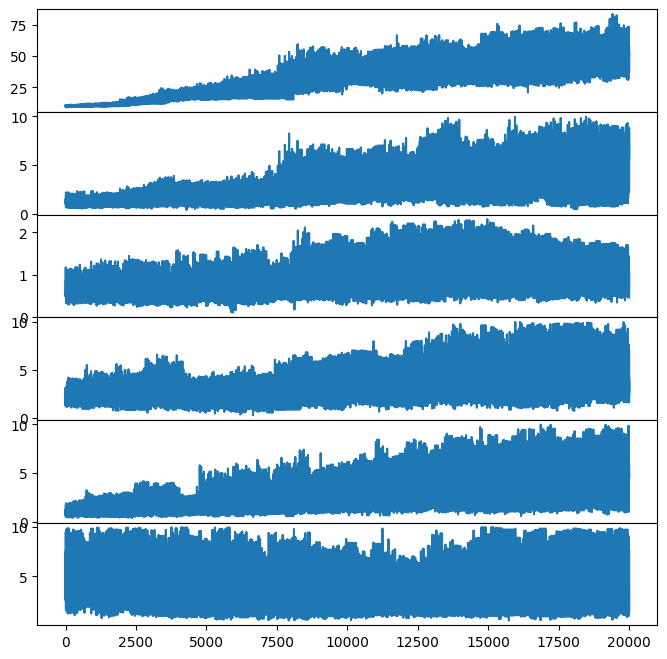

In [20]:
flat_samples = init[-1][:,:6]
fig, ax = plt.subplots(6,1, sharex=True, figsize=(8,8))
fig.subplots_adjust(hspace=0,wspace=0)

ax[0].plot(flat_samples[:20000,0])
ax[1].plot(flat_samples[:20000,1])
ax[2].plot(flat_samples[:20000,2])
ax[3].plot(flat_samples[:20000,3])
ax[4].plot(flat_samples[:20000,4])
ax[5].plot(flat_samples[:20000,5])

(60000, 6)


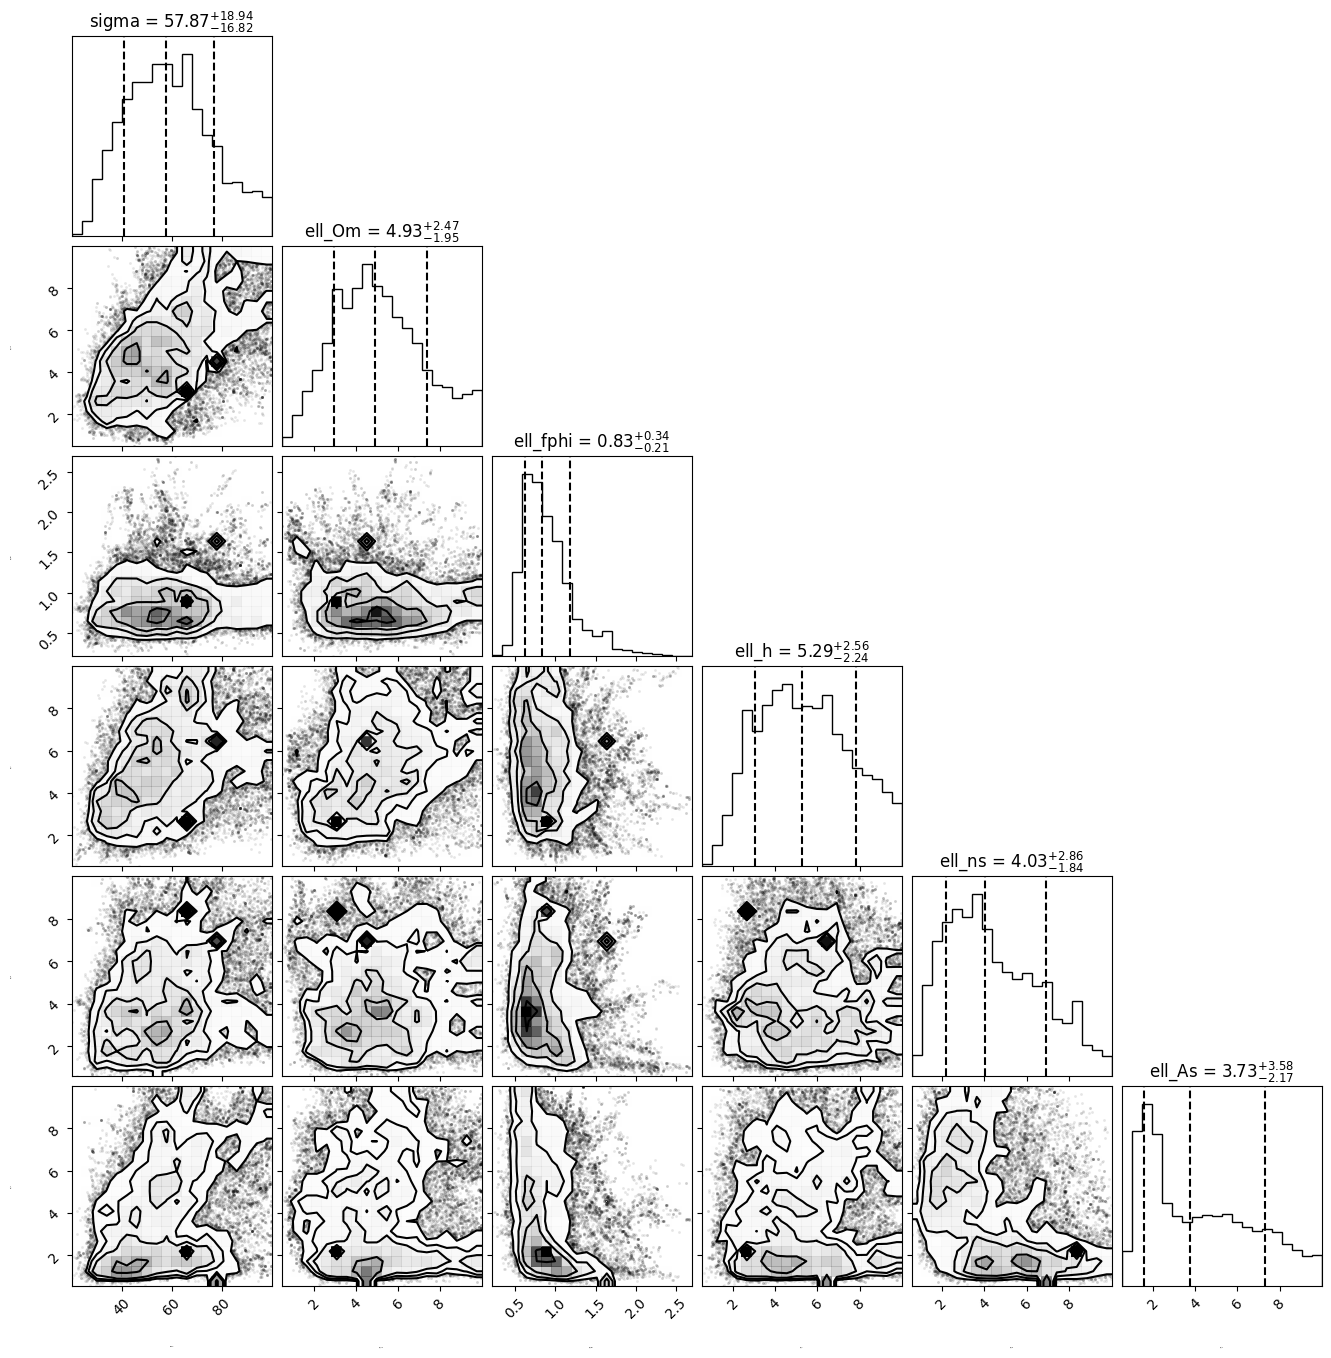

In [21]:
print(flat_samples.shape)
labels = [ "sigma", "ell_Om" ,"ell_fphi", "ell_h","ell_ns", "ell_As"]

fig = corner.corner(
    flat_samples[10000:], labels=labels, show_titles=True, quantiles=[0.16, 0.50, 0.84],
                    label_kwargs={'labelpad':20, 'fontsize':0}, fontsize=8
);

## Use the emulator: recover training data

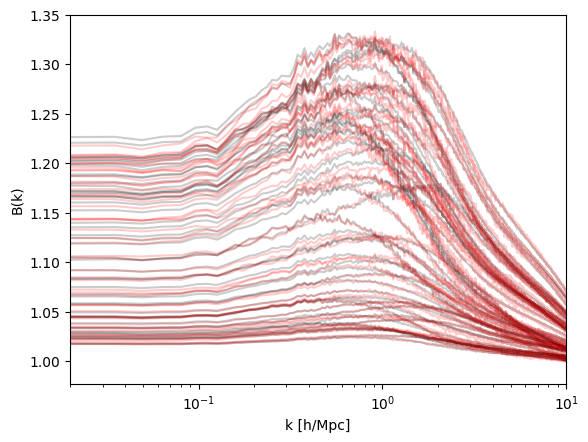

In [24]:
Bk_new = B_k_emu(init, theta_1)

for sim_index in range(len(Bk_new)):
    plt.plot(k_arr, Bk_new[sim_index], 'k', alpha=0.2)
    plt.plot(k_arr, Bk_arr[sim_index, 0, :], 'r', alpha=0.2)

f1 = plt.plot([1,1], [1,1], 'k', alpha=0.2, label="data from emulator")
f2 = plt.plot([1,1], [1,1], 'r', alpha=0.2, label="training dataset")
f1 = f1.pop(0)
f2 = f2.pop(0)

f1.remove()
f2.remove()

plt.ylabel("B(k)")
plt.xlim(2e-2,1e1)

plt.xlabel("k [h/Mpc]")
plt.xscale("log")

In [265]:
## Testing emulator for a single point
"""
theta_new = np.array([[0.13,0.8,0.899, 1.0, 0.8]]).T
print(theta_new)
Bk_new, Bkup, Bklow = B_k_emu(init, theta_new)

# Plot all data to be sure test data is within emulator bounds
df_point = pd.DataFrame(theta_new.T, columns=['wm','f_phi', 'E_dS', 'n_s', 'sigma8'][:len(theta_1)])
sns.pairplot(pd.concat([df_theta.assign(hue='dat'), 
                        df_point.assign(hue='dat2')]), 
             hue='hue', 
             diag_kind='hist',
             palette=['b', 'r'])
#pd.plotting.scatter_matrix(df_theta)
#pd.plotting.scatter_matrix(df_point)
plt.show()

for sim_index in range(1):
    sim_index = 0
    plt.plot(k_arr, Bk_new[sim_index], 'k', alpha=0.7)
    plt.plot(k_arr, Bkup[sim_index], 'b--', alpha=0.2)
    plt.plot(k_arr, Bklow[sim_index], 'b--', alpha=0.2)
    #plt.plot(k_arr, Bk_arr[sim_index, 0, :], 'r', alpha=0.2)

plt.xscale("log")

"""

'\ntheta_new = np.array([[0.13,0.8,0.899, 1.0, 0.8]]).T\nprint(theta_new)\nBk_new, Bkup, Bklow = B_k_emu(init, theta_new)\n\n# Plot all data to be sure test data is within emulator bounds\ndf_point = pd.DataFrame(theta_new.T, columns=[\'wm\',\'f_phi\', \'E_dS\', \'n_s\', \'sigma8\'][:len(theta_1)])\nsns.pairplot(pd.concat([df_theta.assign(hue=\'dat\'), \n                        df_point.assign(hue=\'dat2\')]), \n             hue=\'hue\', \n             diag_kind=\'hist\',\n             palette=[\'b\', \'r\'])\n#pd.plotting.scatter_matrix(df_theta)\n#pd.plotting.scatter_matrix(df_point)\nplt.show()\n\nfor sim_index in range(1):\n    sim_index = 0\n    plt.plot(k_arr, Bk_new[sim_index], \'k\', alpha=0.7)\n    plt.plot(k_arr, Bkup[sim_index], \'b--\', alpha=0.2)\n    plt.plot(k_arr, Bklow[sim_index], \'b--\', alpha=0.2)\n    #plt.plot(k_arr, Bk_arr[sim_index, 0, :], \'r\', alpha=0.2)\n\nplt.xscale("log")\n\n'

## Sensitivity analysis from the emulator 

In [40]:
# For each of the parameters, we fix all other parameters to some fiducial values and vary the one parameter linearly

# 'Omega_m','f_phi', 'h', 'n_s', 'A_s'

theta_new1 = np.array([np.linspace(0.225,0.3, 50), np.ones(50)*0.5 , np.ones(50)*0.67, np.ones(50)*0.96, np.ones(50)*2.01e-9])
theta_new2 = np.array([np.ones(50)*0.25, np.linspace(0.0,1.0, 50) , np.ones(50)*0.67, np.ones(50)*0.96, np.ones(50)*2.01e-9])
theta_new3 = np.array([np.ones(50)*0.25, np.ones(50)*0.5 , np.linspace(0.6,0.75, 50), np.ones(50)*0.96, np.ones(50)*2.01e-9])
theta_new4 = np.array([np.ones(50)*0.25, np.ones(50)*0.5 , np.ones(50)*0.67, np.linspace(0.9,1.1, 50), np.ones(50)*2.01e-9])
theta_new5 = np.array([np.ones(50)*0.25, np.ones(50)*0.5 , np.ones(50)*0.67, np.ones(50)*0.96, np.linspace(1.9e-9,3e-9, 50)])


Bk_new1 = B_k_emu(init, theta_new1)
Bk_new2 = B_k_emu(init, theta_new2)
Bk_new3 = B_k_emu(init, theta_new3)
Bk_new4 = B_k_emu(init, theta_new4)
Bk_new5 = B_k_emu(init, theta_new5)


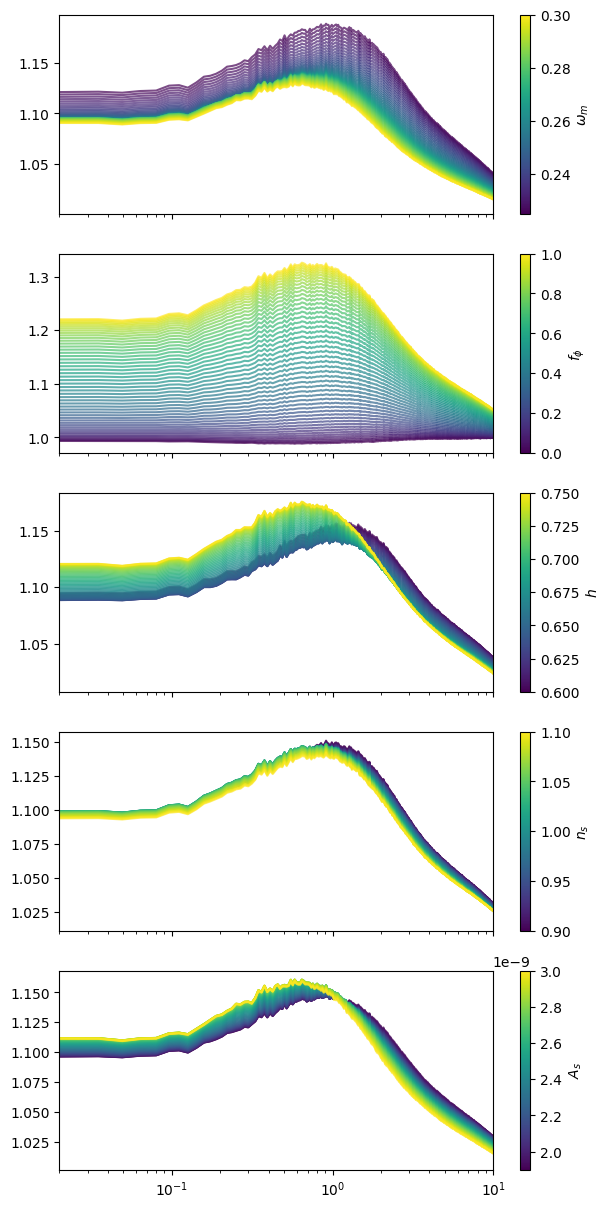

In [43]:
cmap = matplotlib.colormaps['viridis']

f, ax = plt.subplots(5, sharex=True, sharey=False,figsize=(7, 15))

frac1 = (theta_new1[0] - min(theta_new1[0]))/(max(theta_new1[0])-min(theta_new1[0]))
frac2 = (theta_new2[1] - min(theta_new2[1]))/(max(theta_new2[1])-min(theta_new2[1]))
frac3 = (theta_new3[2] - min(theta_new3[2]))/(max(theta_new3[2])-min(theta_new3[2]))
frac4 = (theta_new4[3] - min(theta_new4[3]))/(max(theta_new4[3])-min(theta_new4[3]))
frac5 = (theta_new5[4] - min(theta_new5[4]))/(max(theta_new5[4])-min(theta_new5[4]))

for sim_index in range(50):
    ax[0].plot(k_arr, Bk_new1[sim_index], color = cmap(frac1[sim_index]), alpha=0.7)
    ax[1].plot(k_arr, Bk_new2[sim_index], color = cmap(frac2[sim_index]), alpha=0.7)
    ax[2].plot(k_arr, Bk_new3[sim_index], color = cmap(frac3[sim_index]), alpha=0.7)
    ax[3].plot(k_arr, Bk_new4[sim_index], color = cmap(frac4[sim_index]), alpha=0.7)
    ax[4].plot(k_arr, Bk_new5[sim_index], color = cmap(frac5[sim_index]), alpha=0.7)
    #plt.plot(k_arr, Bk_arr[sim_index, 0, :], 'r', alpha=0.2)
plt.xscale("log")

norm = matplotlib.colors.Normalize(vmin=min(theta_new1[0]), vmax=max(theta_new1[0]))
f.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), ax = ax[0], orientation='vertical', label=r'$\omega_m$')
norm = matplotlib.colors.Normalize(vmin=min(theta_new2[1]), vmax=max(theta_new2[1]))
f.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), ax = ax[1], orientation='vertical', label=r'$f_{\phi}$')
norm = matplotlib.colors.Normalize(vmin=min(theta_new3[2]), vmax=max(theta_new3[2]))
f.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), ax = ax[2], orientation='vertical', label=r'$h$')
norm = matplotlib.colors.Normalize(vmin=min(theta_new4[3]), vmax=max(theta_new4[3]))
f.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), ax = ax[3], orientation='vertical', label=r'$n_s$')
norm = matplotlib.colors.Normalize(vmin=min(theta_new5[4]), vmax=max(theta_new5[4]))
f.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), ax = ax[4], orientation='vertical', label=r'$A_s$')


ax[0].set_xlim(2e-2,1e1)
plt.show()